In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


def plot_time_series(time, values, label, smooth=0, repeat=1):
    n = len(time)
    x_and_label = {i: label for i, label in enumerate(time*repeat)}
    update_ticks = lambda x, pos: x_and_label[x] if x in x_and_label.keys() else ""

    values = values * repeat
    time = list(x_and_label.keys())

    if smooth:
        x_new = np.linspace(min(time), max(time), 100)
        spline = make_interp_spline(time, values)
        values = spline(x_new)
        time = x_new

    # plot
    ax = plt.subplot()
    ax.plot(time, values)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    # labels
    ax.set_xlabel("Time", fontsize=10)
    ax.set_ylabel("Value", fontsize=10)
    plt.title(label, fontsize=20)
    plt.grid(True)

In [3]:
from datetime import datetime
from dataclasses import dataclass
from typing import List, Optional

import pandas as pd
import numpy as np 


class Trend:
    def __init__(self, slope: float = 0):
        self.slope = slope

    def get_value(self, start_ts: datetime, ts: datetime, base_value: Optional[float] = 0) -> float:
        x = (ts - start_ts).days
        return base_value + self.slope * x


class Sazonality:
    def __init__(
        self,
        week_days: Optional[List[float]] = None,
        month_period: Optional[List[float]] = None,
        year_months: Optional[List[float]] = None
    ):
        self.week_days = week_days or [1]*7
        self.month_period = month_period or [1]*3
        self.year_months = year_months or [1]*12

    def get_week_days_constant(self, ts: datetime) -> float:
        return self.week_days[ts.weekday()]

    def get_month_period_constant(self, ts: datetime) -> float:
        if ts.day > 20:
            return self.month_period[2]
        if ts.day > 10:
            return self.month_period[1]
        return self.month_period[0]

    def get_year_months_constant(self, ts: datetime) -> float:
        return self.year_months[ts.month - 1]

    def get_constant(self, ts: datetime) -> float:
        return self.get_week_days_constant(ts) * self.get_month_period_constant(ts) * self.get_year_months_constant(ts)


class Noise:
    def __init__(self, mean: float = 1, var: float = 0, seed: Optional[int] = None, generator = None):
        self.generator = generator or np.random.default_rng(seed=seed)
        self.mean = mean
        self.var = var

    def generate(self) -> float:
        return self.generator.normal(loc=self.mean, scale=self.var)


@dataclass(frozen=True)
class TimeSeries:
    date_points: np.ndarray
    value_points: np.ndarray
#     trend_points: np.ndarray
#     sazonality_points: np.ndarray
#     noise_points: np.ndarray


class TimeSeriesGenerator:
    def __init__(
        self,
        trend: Optional[Trend] = None,
        sazonality: Optional[Sazonality] = None,
        noise: Optional[Noise] = None,
    ):
        self.trend = trend or Trend()
        self.sazonality = sazonality or Sazonality()
        self.noise = noise or Noise()

    def generate(self, start_date: datetime, base_value: float, n: int) -> "TimeSeriesGenerator":
        date_points = pd.date_range(
            datetime(year=2021, month=1, day=1), periods=n
        ).to_list()
        start_ts = date_points[0]

        trend_points = np.fromiter(
            (
                trend_spec.get_value(
                    start_ts=start_ts , ts=ts, base_value=base_value
                ) for ts in date_points
            ),
            dtype=float
        )
        sazonality_points = np.fromiter(
            (self.sazonality.get_constant(ts) for ts in date_points),
            dtype=float
        )
        noise_points = np.fromiter(
            (self.noise.generate() for ts in date_points),
            dtype=float
        )
        value_points = trend_points * sazonality_points * noise_points
        return TimeSeries(date_points=date_points, value_points=value_points)


In [4]:
start_ts = datetime(year=2021, month=1, day=1)
date_points = pd.date_range(start_ts, periods=50).to_list()
type(date_points[0])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
week_labels = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
week_sazonality = [0.85, 0.9, 1, 1, 0.9, 0.8, 0.8]

month_labels = ["begin", "middle", "end"]
month_sazonality = [1, 0.9, 1]

year_labels = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
year_sazonality = [1, 0.95, 0.9, 0.9, 0.85, 0.85, 0.85, 0.85, 0.9, 0.9, 0.95, 1]

sazonality_spec = Sazonality(
    week_days=week_sazonality,
    #month_period=month_sazonality,
    year_months=year_sazonality
)

trend_spec = Trend(slope=5)

noise_spec = Noise(var=0.05)

time_series_generator = TimeSeriesGenerator(
    trend=trend_spec,
    sazonality=sazonality_spec,
    #noise=noise_spec
)


In [6]:
time_series = time_series_generator.generate(
    start_date=datetime(year=2020, month=1, day=1),
    base_value=1000,
    n=365*3
)

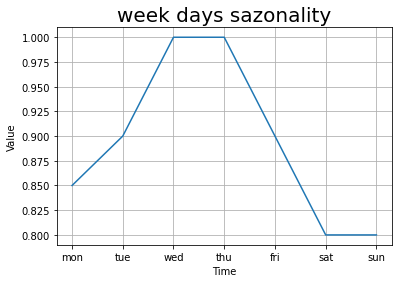

In [7]:
# show week sazonality
plot_time_series(
    time=week_labels,
    values=week_sazonality,
    label="week days sazonality",
)

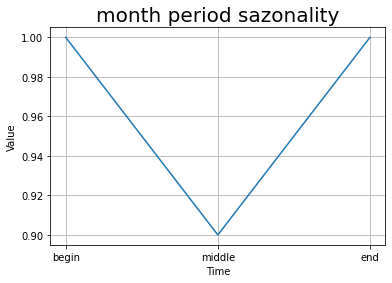

In [8]:
# show month sazonality
plot_time_series(
    time=month_labels,
    values=month_sazonality,
    label="month period sazonality",
)

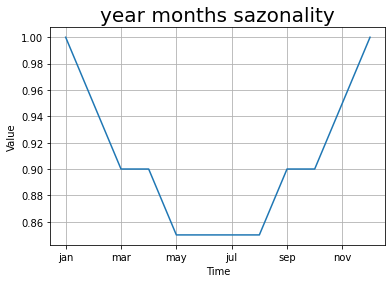

In [9]:
# show year sazonality
plot_time_series(
    time=year_labels,
    values=year_sazonality,
    label="year months sazonality",
)

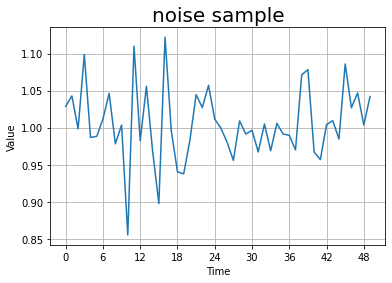

In [10]:
# show noise sample
plot_time_series(
    time=[i for i in range(50)],
    values=[noise_spec.generate() for i in range(50)],
    label="noise sample",
)

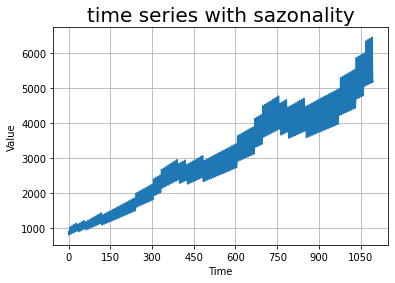

In [11]:
# show time series
plot_time_series(
    time=[i for i, _ in enumerate(time_series.date_points)],
    values=time_series.value_points,
    label="time series with sazonality"
)

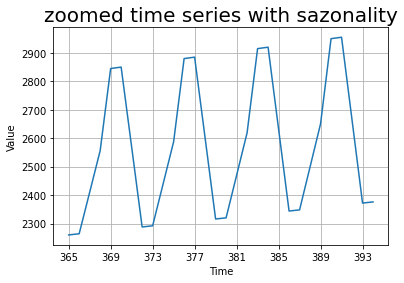

In [12]:
# show zoomed time series

plot_time_series(
    time=[i for i, _ in enumerate(time_series.date_points)][365:395],
    values=time_series.value_points[365:395],
    label="zoomed time series with sazonality"
)

## Forecasting/Anomally Detection Libs

In [13]:
import pandas as pd
from prophet import Prophet

df = pd.DataFrame(
    {"ds": time_series.date_points, "y": time_series.value_points}
)
df_train = pd.DataFrame(
    {"ds": time_series.date_points[:875],
     "y": time_series.value_points[:875]}
)

Importing plotly failed. Interactive plots will not work.


In [14]:
model = Prophet(
    seasonality_mode="multiplicative",
)

In [15]:
model.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
future = model.make_future_dataframe(periods=15)

In [17]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-01,902.914131,864.761727,943.072746
1,2021-01-02,813.733318,775.218740,853.832074
2,2021-01-03,817.748456,778.055055,857.576600
3,2021-01-04,868.751410,829.977855,909.435479
4,2021-01-05,920.929337,883.051748,962.370917
...,...,...,...,...
885,2023-06-05,3923.677560,3882.154951,3962.732806
886,2023-06-06,4171.980987,4133.270077,4212.996251
887,2023-06-07,4655.796151,4617.693735,4694.388250
888,2023-06-08,4668.191311,4627.041854,4706.882708


In [28]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-01-01,827.978077,864.761727,943.072746,827.978077,827.978077,0.090505,0.090505,0.090505,0.008560,0.008560,0.008560,0.081945,0.081945,0.081945,0.0,0.0,0.0,902.914131
1,2021-01-02,831.713260,775.218740,853.832074,831.713260,831.713260,-0.021618,-0.021618,-0.021618,-0.104082,-0.104082,-0.104082,0.082464,0.082464,0.082464,0.0,0.0,0.0,813.733318
2,2021-01-03,835.448443,778.055055,857.576600,835.448443,835.448443,-0.021186,-0.021186,-0.021186,-0.104270,-0.104270,-0.104270,0.083084,0.083084,0.083084,0.0,0.0,0.0,817.748456
3,2021-01-04,839.183626,829.977855,909.435479,839.183626,839.183626,0.035234,0.035234,0.035234,-0.048560,-0.048560,-0.048560,0.083794,0.083794,0.083794,0.0,0.0,0.0,868.751410
4,2021-01-05,842.918809,883.051748,962.370917,842.918809,842.918809,0.092548,0.092548,0.092548,0.007972,0.007972,0.007972,0.084576,0.084576,0.084576,0.0,0.0,0.0,920.929337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,2023-06-05,4293.604183,3882.154951,3962.732806,4293.237021,4293.820846,-0.086158,-0.086158,-0.086158,-0.048560,-0.048560,-0.048560,-0.037598,-0.037598,-0.037598,0.0,0.0,0.0,3923.677560
886,2023-06-06,4296.582190,4133.270077,4212.996251,4296.014702,4296.954379,-0.029000,-0.029000,-0.029000,0.007972,0.007972,0.007972,-0.036972,-0.036972,-0.036972,0.0,0.0,0.0,4171.980987
887,2023-06-07,4299.560198,4617.693735,4694.388250,4298.849741,4300.095352,0.082854,0.082854,0.082854,0.119317,0.119317,0.119317,-0.036463,-0.036463,-0.036463,0.0,0.0,0.0,4655.796151
888,2023-06-08,4302.538206,4627.041854,4706.882708,4301.676962,4303.249611,0.084985,0.084985,0.084985,0.121062,0.121062,0.121062,-0.036077,-0.036077,-0.036077,0.0,0.0,0.0,4668.191311


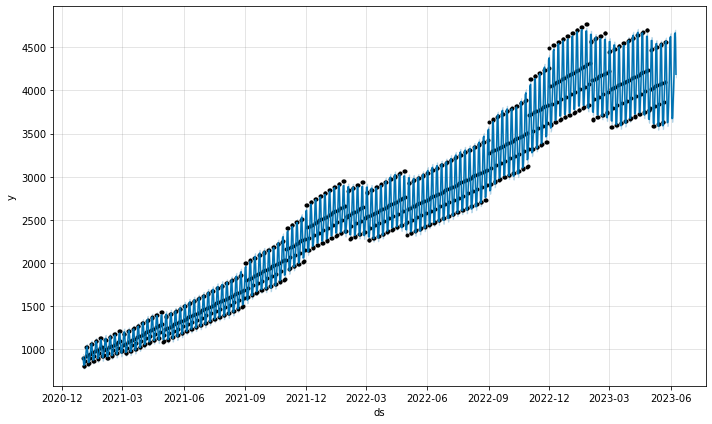

In [18]:
fig1 = model.plot(forecast)

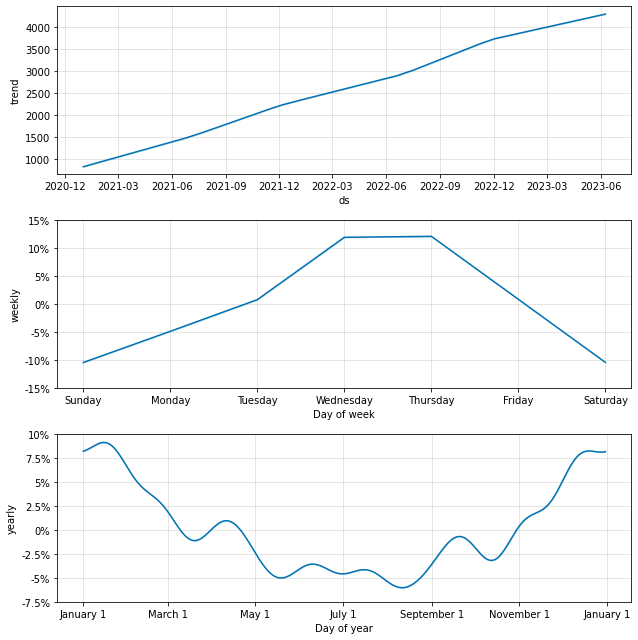

In [19]:
fig2 = model.plot_components(forecast)

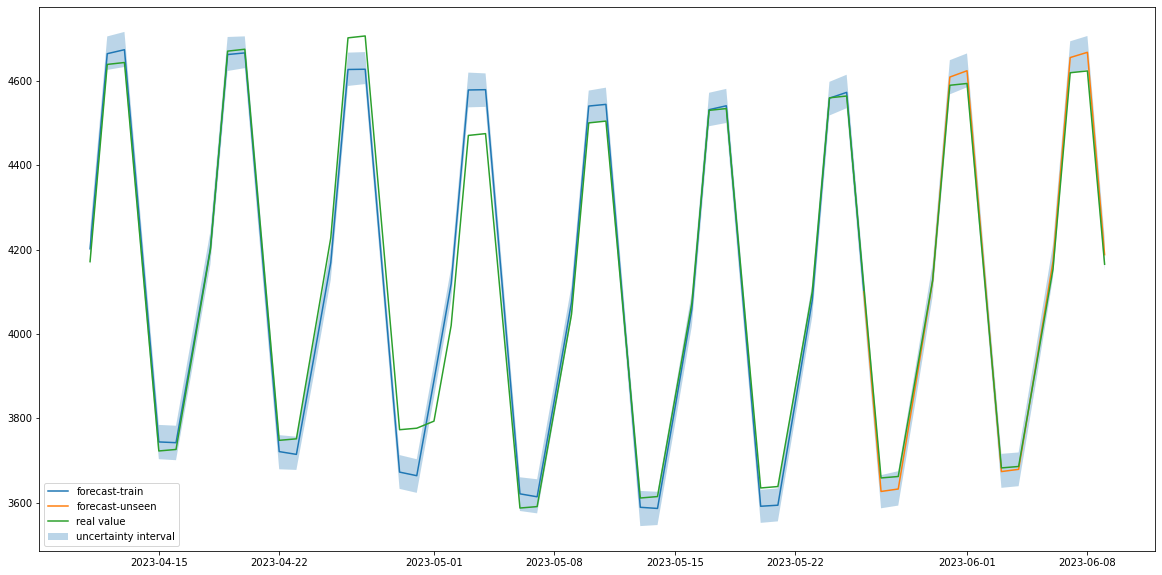

In [20]:
def plot_compare_predict_and_time_series(forecast_pdf, unseen_n, ts, lower_bound = None, upper_bound = None):
    plt.figure(figsize=(20,10))
    plt.plot(
        forecast_pdf["ds"][lower_bound:upper_bound-unseen_n + 1],
        forecast_pdf["yhat"][lower_bound:upper_bound-unseen_n + 1],
        label="forecast-train",
    )
    plt.plot(
        forecast_pdf["ds"][upper_bound-unseen_n:upper_bound],
        forecast_pdf["yhat"][upper_bound-unseen_n:upper_bound],
        label="forecast-unseen",
    )
    plt.fill_between(
        x=forecast_pdf["ds"][lower_bound:upper_bound],
        y1=forecast_pdf["yhat_lower"][lower_bound:upper_bound],
        y2=forecast_pdf["yhat_upper"][lower_bound:upper_bound],
        alpha=0.3,
        label="uncertainty interval"
    )
    plt.plot(forecast_pdf["ds"][lower_bound:upper_bound], ts.value_points[lower_bound:upper_bound], label="real value")
    plt.legend()
    plt.show()

lower_bound = 830
upper_bound = 890
plot_compare_predict_and_time_series(
    forecast_pdf=forecast,
    unseen_n=15,
    ts=time_series,
    lower_bound=lower_bound,
    upper_bound=upper_bound
)



In [21]:
def absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.abs((y_true - y_pred) / y_true)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(absolute_percentage_error(y_true, y_pred)))

def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))

In [22]:
mean_absolute_percentage_error(forecast["yhat"], time_series.value_points[:890])

0.008444325000647734

In [23]:
max_absolute_percentage_error(forecast["yhat"], time_series.value_points[:890])

0.031207069905107566

(array([ 94., 106., 108., 117.,  98.,  88.,  53.,  35.,  26.,  18.,  20.,
         28.,  15.,  29.,  12.,  23.,   5.,   7.,   5.,   3.]),
 array([3.88703349e-05, 1.59728031e-03, 3.15569029e-03, 4.71410027e-03,
        6.27251025e-03, 7.83092023e-03, 9.38933021e-03, 1.09477402e-02,
        1.25061502e-02, 1.40645601e-02, 1.56229701e-02, 1.71813801e-02,
        1.87397901e-02, 2.02982001e-02, 2.18566100e-02, 2.34150200e-02,
        2.49734300e-02, 2.65318400e-02, 2.80902499e-02, 2.96486599e-02,
        3.12070699e-02]),
 <BarContainer object of 20 artists>)

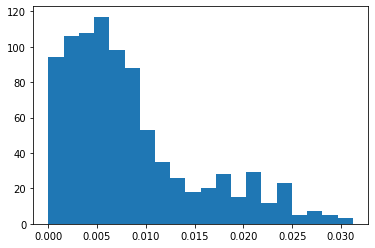

In [24]:
percentage_errors = absolute_percentage_error(forecast["yhat"], time_series.value_points[:890])
percentage_errors.sort()
plt.hist(percentage_errors, bins=20)

In [25]:
np.percentile(percentage_errors, 75)

0.011103979471213143

In [26]:
np.percentile(percentage_errors, 95)

0.022917739876327548

In [27]:
np.percentile(percentage_errors, 99)

0.027302887280853914